# 🌍 Intel Image Classification – CNN + Transfer Learning
## 1. Kapsam
Bu notebook, **Akbank Derin Öğrenme Bootcamp** kapsamında hazırlanmıştır. Amaç, doğal ve yapay ortamları sınıflandırmak ve modern deep learning tekniklerini uygulamaktır.

In [2]:
# ==========================
# 1. Gerekli Kütüphaneler
# ==========================

import tensorflow as tf

from tensorflow.keras.mixed_precision import set_global_policy

# Mixed Precision politikasını 'mixed_float16' olarak ayarlayın
set_global_policy('mixed_float16')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import datetime
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# TensorFlow version ve GPU bilgisi
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 📥 2. Veri Seti
- Kaggle Dataset: [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
- Eğitim: ~25.000 görüntü
- Test: ~14.000 görüntü
- Sınıflar: Buildings, Forest, Glacier, Mountain, Sea, Street

In [3]:
# Veri yolları (Kaggle ortamında dataset eklenmiş olmalı)
data_dir = '/kaggle/input/intel-image-classification'
train_dir = os.path.join(data_dir, 'seg_train/seg_train')
test_dir  = os.path.join(data_dir, 'seg_test/seg_test')

print(os.listdir(data_dir))
print('train_dir exists:', os.path.exists(train_dir))
print('test_dir exists:', os.path.exists(test_dir))

['seg_train', 'seg_pred', 'seg_test']
train_dir exists: True
test_dir exists: True


## 🧹 3. Veri Önişleme & Data Augmentation
- Eğitim setine Data Augmentation uygulanacak:
  - Döndürme (rotation)
  - Zoom
  - Flip
- Test seti normalize edilecek

In [4]:
# Veri işleme ve Data Augmentation
img_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_labels = list(train_gen.class_indices.keys())
print("Sınıf etiketleri:", class_labels)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Sınıf etiketleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## 🏗️ 4. CNN Modeli (Baseline)
- 3 Convolutional Layer + MaxPooling
- Fully connected Dense layer
- Dropout (%50)

In [6]:
# ==========================
# 4. CNN MODELİ (Kontrol için)
# ==========================
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## 📈 5. TensorBoard & W&B Callback Hazırlığı

In [7]:
# ==========================
# 5. TensorBoard & W&B Callback Hazırlığı
# ==========================
wandb.init(
    project="intel-image-classification",
    name="cnn_baseline",
    mode="offline",
    reinit=True
)

tensorboard_cb = TensorBoard(
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    histogram_freq=0
)

wandb_metrics_cb = WandbMetricsLogger()

# WandbModelCheckpoint hatasını önlemek için save_best_only=False yapıldı
wandb_checkpoint_cb = WandbModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',
    save_best_only=False,
    monitor='val_loss'
)

callbacks_list = [tensorboard_cb, wandb_metrics_cb, wandb_checkpoint_cb]

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


## 6. Model Eğitimi (CNN)

Train ve validation verisi ile model eğitilir.

In [8]:
print("--- CNN Model Eğitimi Başlıyor ---")
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks_list
)

--- CNN Model Eğitimi Başlıyor ---
Epoch 1/20


I0000 00:00:1758725301.352969     759 service.cc:148] XLA service 0x7a436000e870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758725301.353015     759 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758725301.650200     759 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758725305.234847     759 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 234ms/step - accuracy: 0.3825 - loss: 1.7940 - val_accuracy: 0.5774 - val_loss: 1.0651
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step - accuracy: 0.5806 - loss: 1.0838 - val_accuracy: 0.6512 - val_loss: 0.9115
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 219ms/step - accuracy: 0.6308 - loss: 0.9813 - val_accuracy: 0.6922 - val_loss: 0.8282
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 77s 220ms/step - accuracy: 0.6555 - loss: 0.9162 - val_accuracy: 0.7257 - val_loss: 0.7468
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.6880 - loss: 0.8373 - val_accuracy: 0.7329 - val_loss: 0.7398
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.7184 - loss: 0.7829 - val_accuracy: 0.7336 - val_loss: 0.7257
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 227ms/step - accuracy: 0.7339 - loss: 0.7321 - val_accuracy: 0.7636 - val_loss: 0.6620
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.7499 - loss: 0.7056 - val

## 📊 7. Eğitim Grafikleri

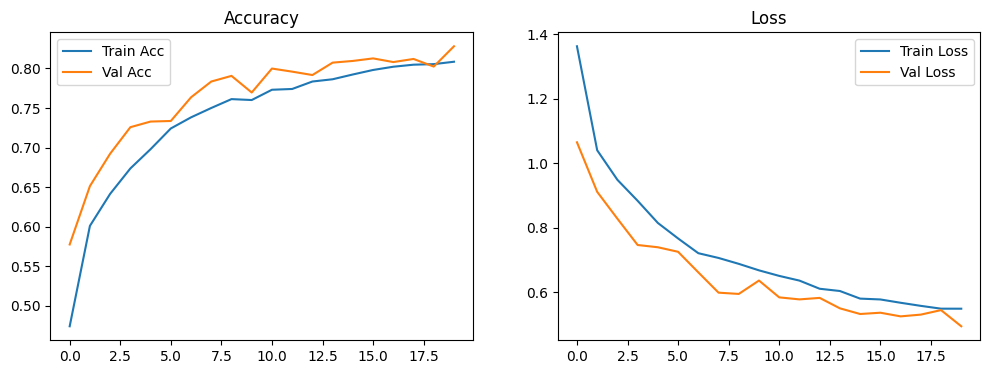

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

## ✅ 8. Model Değerlendirme

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step
              precision    recall  f1-score   support

   buildings       0.82      0.86      0.84       437
      forest       0.97      0.95      0.96       474
     glacier       0.83      0.80      0.82       553
    mountain       0.80      0.80      0.80       525
         sea       0.86      0.88      0.87       510
      street       0.87      0.87      0.87       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



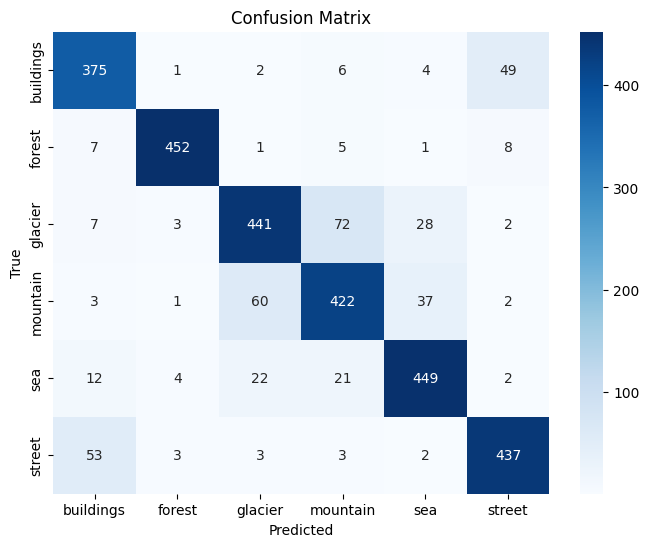

In [10]:
y_pred = cnn_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred_classes, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## 🔥 9. Grad-CAM

Sınıf: sea
Resim Yolu: /kaggle/input/intel-image-classification/seg_test/seg_test/sea/20283.jpg
Gerçek Sınıf: sea


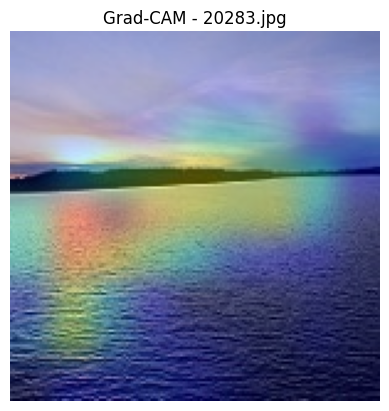

In [11]:
# ==========================
# Grad-CAM Fonksiyonları
# ==========================

# VGG16 modelinin evrişimli tabanını oluşturun
vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

# Yeni katmanları ekleyerek kendi modelimizi oluşturun
x = vgg_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x) # 6 sınıf olduğu için 6 nöron

# Tam modelimizi tanımlayın
vgg_model = Model(inputs=vgg_base.input, outputs=predictions)

# Modeli derleyin
vgg_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

def get_img_array(img_path, target_size):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    array = tf.keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, original_image=None):
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    jet = plt.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM - {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()

# Örnek görüntüleri al ve tahmin yap
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
test_class_names = os.listdir(test_dir)
random_class = random.choice(test_class_names)
random_class_path = os.path.join(test_dir, random_class)
random_image = random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image)

print(f"Sınıf: {random_class}")
print(f"Resim Yolu: {random_image_path}")
print(f"Gerçek Sınıf: {random_class}")

# VGG16 modelinin son evrişimli katmanını doğru şekilde belirtin
last_conv_layer_name = "block5_conv3"
img_size = (150, 150)

# Resmi yükle ve modele hazırla
img_array = get_img_array(random_image_path, img_size)

# Grad-CAM hesaplaması
heatmap = make_gradcam_heatmap(img_array, vgg_model, last_conv_layer_name)

# Görselleştirme
display_gradcam(random_image_path, heatmap)

## 🌟 10. Transfer Learning – VGG16

In [12]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

tl_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(6, activation="softmax")
])

tl_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
tl_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,813,638 (64.14 MB)

 Trainable params: 2,098,950 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 11. Transfer Learning Model Eğitimi

In [13]:
# Önceki WandB oturumunu güvenle sonlandırın
wandb.finish()

# Şimdi yeni bir WandB oturumu başlatın
wandb.init(project="intel-image-classification", name="vgg16_transfer", mode="offline", reinit=True)

# Eğitim kodunuz aynen devam edebilir
tl_history = tl_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[WandbMetricsLogger()]
)

epoch/accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▅▅▆▇▇▆▇▇▇▇▇█▇█▇█
epoch/val_loss,█▆▅▄▄▄▃▂▂▃▂▂▂▂▁▂▁▁▂▁
epoch/accuracy,0.80855
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.54937
epoch/val_accuracy,0.8281


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 95s 249ms/step - accuracy: 0.6210 - loss: 1.0286 - val_accuracy: 0.7999 - val_loss: 0.5216
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 222ms/step - accuracy: 0.7693 - loss: 0.6154 - val_accuracy: 0.8170 - val_loss: 0.4665
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.7873 - loss: 0.5669 - val_accuracy: 0.8335 - val_loss: 0.4566
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.7964 - loss: 0.5343 - val_accuracy: 0.8327 - val_loss: 0.4453
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.8063 - loss: 0.5134 - val_accuracy: 0.8228 - val_loss: 0.4546
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.8035 - loss: 0.5164 - val_accuracy: 0.8320 - val_loss: 0.4478
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 225ms/step - accuracy: 0.8157 - loss: 0.5063 - val_accuracy: 0.8285 - val_loss: 0.4465
Epoch 8/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 78s 223ms/step - accuracy: 0.8099 - loss: 0

## 📊 Transfer Learning Sonuçları

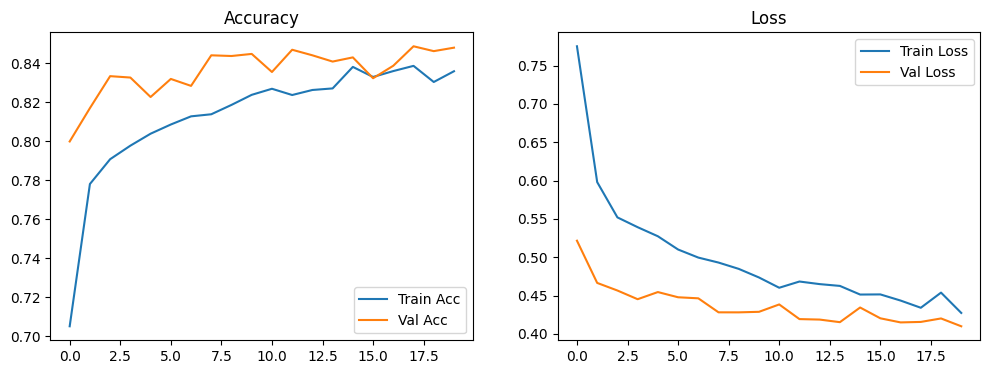

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(tl_history.history["accuracy"], label="Train Acc")
plt.plot(tl_history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(tl_history.history["loss"], label="Train Loss")
plt.plot(tl_history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()



## ✅ 12. Transfer Learning Değerlendirme

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step
              precision    recall  f1-score   support

   buildings       0.88      0.92      0.90       437
      forest       0.98      0.97      0.97       474
     glacier       0.79      0.84      0.82       553
    mountain       0.85      0.74      0.79       525
         sea       0.85      0.89      0.87       510
      street       0.91      0.90      0.91       501

    accuracy                           0.87      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.87      0.87      0.87      3000



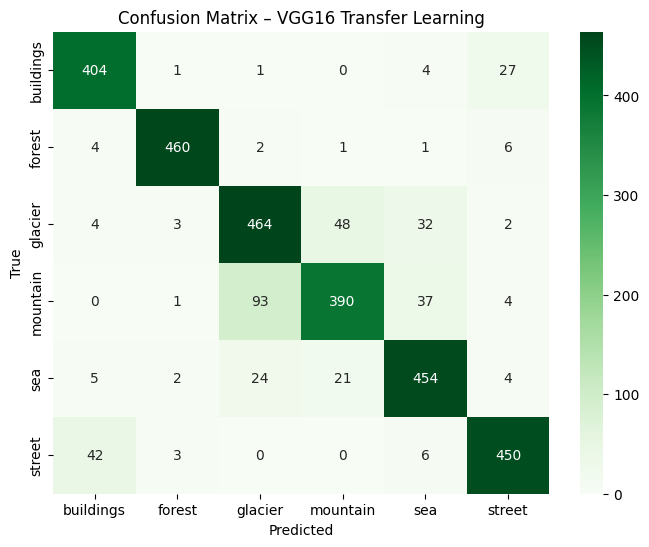

In [15]:
y_true = test_gen.classes

# Daha sonra model tahminlerini yapın
y_pred_tl = tl_model.predict(test_gen)
y_pred_classes_tl = np.argmax(y_pred_tl, axis=1)

print(classification_report(y_true, y_pred_classes_tl, target_names=list(test_gen.class_indices.keys())))

cm_tl = confusion_matrix(y_true, y_pred_classes_tl)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tl, annot=True, fmt="d", cmap="Greens", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – VGG16 Transfer Learning")
plt.show()